In [1]:
from __future__ import division
from __future__ import print_function
from __future__ import absolute_import

In [2]:
%matplotlib inline

import sys
import inspect

import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
from tensorflow import feature_column as fc
from tools import print_progress, array_in, create_input_data

In [3]:
# create a function of x that returns random samples around a*x+b
def make_lin(a, b, rnd):
    def _f_a(x):
        mu = a*x + b
        return rnd(mu)
    return _f_a

In [4]:
f_a = make_lin(2, 1, lambda mu: np.random.normal(loc=mu, scale=1.0))
f_b = make_lin(-.5, -1.5, lambda mu: np.random.normal(loc=mu, scale=1.0))

In [5]:
try:
    sess.close()
except:
    print("OK. Was already closed or didn't exist. That's fine.")
    
sess = tf.InteractiveSession()

OK. Was already closed or didn't exist. That's fine.


In [6]:
# create a function of x that returns random samples around a constant, if the hour of week 
conditions = np.array([
    (0, 18), (0, 19), (0, 20), (0, 21), # Mondays
    (1, 18), (1, 19), (1, 20), (1, 21), # Tuesdays
    (2, 18), (2, 19), (2, 20), (2, 21), # Wednesdays
    # closed on Thursdays
    (4, 14), (4, 15), (4, 16),          # Fridays
    (5, 14), (5, 15), (5, 16)           # Saturdays
    # closed on Sundays
    ])

def make_noisy_amplitude_function(amplitude):
    def _f(c1, c2):
        zipped = zip(c1,c2)
        res = array_in(zipped, conditions)        
        return res * (np.random.normal( 0 * res, .2 ) + amplitude)
    return _f

In [7]:
def create_data_frame_v2(size, amplitude=5.0):
    x_data = np.random.uniform(high=5, low=-5, size=size)
    y_data = np.random.uniform(high=5, low=-5, size=size)
    dow_data = np.random.randint(7, size=size)
    hod_data = np.random.randint(24, size=size)
    f_data = f_a(x_data) + f_b(y_data)
    
    f_special = make_noisy_amplitude_function(amplitude)(dow_data, hod_data)

    f_total = f_data + f_special
    f_perf = -.5 * y_data - 1.5 + 2 * x_data + 1
    df = pd.DataFrame({'x': x_data, 'y': y_data, 'dow': dow_data, 'hod': hod_data, 'f_orig': f_data, 'p': f_perf, 'special': f_special, 'f': f_total})
    return df

In [8]:
NUM_RECORDS = 20000
LIN_DIM = 2
CAT_DIM = 168
EMB_DIM = 3
lr = .05

The weights, including the embedding weights - and the bias

In [9]:
M_emb = tf.Variable(tf.random_normal(shape=(EMB_DIM, CAT_DIM)))
M = tf.Variable(tf.zeros(shape=(1, LIN_DIM + EMB_DIM)))
b = tf.Variable(0.)

The place holders

In [10]:
x_lin = tf.placeholder(shape=(LIN_DIM, None), dtype=tf.float32)
x_cat = tf.placeholder(shape=(CAT_DIM, None), dtype=tf.float32)
lbls = tf.placeholder(shape=(1,None), dtype=tf.float32)

The input data: embed categorical sparse data and concatenate with linear features

In [11]:
x_emb = tf.matmul(M_emb, x_cat)
x = tf.concat([x_lin, x_emb], axis=0)

The hypothesis and the loss

In [12]:
f = tf.matmul(M, x) + b
d = tf.losses.mean_squared_error(lbls, f)

The gradients and the optimizers, now including the embedding matrix

In [13]:
nM = tf.gradients(d, M)
nb = tf.gradients(d, b)
nMe = tf.gradients(d, M_emb)
aM = tf.assign_add( M, tf.multiply(nM[0], -lr))
ab = tf.assign_add( b, tf.multiply(nb[0], -lr))
aMe = tf.assign_add( M_emb, tf.multiply(nMe[0], -lr))

The initializer

In [14]:
init = tf.global_variables_initializer()
sess.run(init)

In [15]:
df_train_v3 = create_data_frame_v2(size = NUM_RECORDS, amplitude=10.0)
input_data_v3 = create_input_data(df=df_train_v3, select_feats=['x', 'y'], cross_feats=[{'dow': 7, 'hod': 24}])    
lbls_data_v3 = [list(df_train_v3['f'])]

Now, please observe how fast the loss converges!

In [16]:
for i in range(1000):
    dist, _, _, _ = sess.run([d, aM, ab, aMe], 
                                   feed_dict = {
                                       x_lin: input_data_v3[:2], 
                                       x_cat: input_data_v3[2:], 
                                       lbls: lbls_data_v3})
    print_progress("- Loss: {}", dist)

- Loss: 2.02579379082

---
Now let's examine the error distribution on some test data once more

In [26]:
df_test_v3 = create_data_frame_v2(size = 20000, amplitude=10.0)
input_data_test_v3 = create_input_data(df=df_test_v3, select_feats=['x', 'y'], cross_feats=[{'dow': 7, 'hod': 24}])

In [27]:
preds = sess.run(f, feed_dict={
    x_lin: input_data_test_v3[:2], 
    x_cat: input_data_test_v3[2:]})

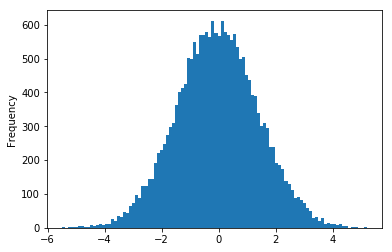

In [28]:
errors = preds[0] - df_test_v3['f']
df_test_v3['preds'] = preds[0]
df_test_v3['err'] = errors
df_test_v3['err'].plot.hist(bins=100);

---
Now let's look at the embedded vectors

In [29]:
embs = sess.run([x_emb], feed_dict={x_cat: input_data_test_v3[2:]})

In [30]:
embs_pd = pd.DataFrame(np.transpose(embs[0]))

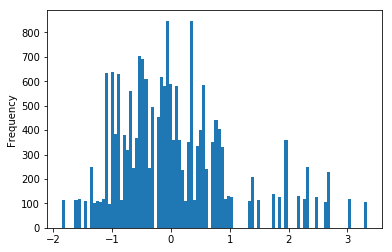

In [31]:
embs_pd[0].plot.hist(bins=100);

We can only assue that the values form two distinct clusters in the embedding space. We suspect that the smaller cluster is made of those dry-cleaner's peek hours.

In [221]:
print(conditions.tolist())

[[0, 18], [0, 19], [0, 20], [0, 21], [1, 18], [1, 19], [1, 20], [1, 21], [2, 18], [2, 19], [2, 20], [2, 21], [4, 14], [4, 15], [4, 16], [5, 14], [5, 15], [5, 16]]
